# Running SVM with Direct Column Selection

This notebook runs the SVM training directly on the markup_data.csv file by selecting only the required columns during runtime, without creating a separate sample file.

## 1. Import Required Libraries

In [10]:
import sys
import os
import subprocess
import re
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

# Set the style for plots
sns.set(style="whitegrid")

## 2. Check the Current Working Directory

In [11]:
print("Current working directory:", os.getcwd())
print("\nFiles in current directory:")
!dir

Current working directory: d:\paper\last_submit

Files in current directory:
 Volume in drive D has no label.
 Volume Serial Number is 187B-B85F

 Directory of d:\paper\last_submit

05/06/2025  02:25 AM    <DIR>          .
05/06/2025  02:21 AM    <DIR>          ..
05/06/2025  02:21 AM               342 .gitignore
05/06/2025  02:21 AM             9,388 attention_rnn_train.py
05/06/2025  02:21 AM    <DIR>          common
05/06/2025  02:28 AM    <DIR>          data
05/06/2025  02:25 AM    <DIR>          graph
05/06/2025  02:21 AM             8,905 hierarchy_svm_svm.py
05/06/2025  02:25 AM    <DIR>          models
05/06/2025  02:21 AM               623 README.md
05/06/2025  02:15 AM                69 requirements.txt
05/06/2025  02:27 AM            17,622 running_svm.ipynb
05/06/2025  02:21 AM             6,508 svm_augment_train.py
05/06/2025  02:21 AM             6,588 svm_for_semi.py
05/06/2025  02:21 AM             6,356 svm_hyperparam_train.py
05/06/2025  02:15 AM             4,518 SVM

## 3. Set Configuration Parameters

In [12]:
# Set the parameters for the script
GRAPH_VER = "1"
ORIGINAL_DATASET_PATH = "data/markup_data.csv"  # Path to the original markup data
N_TRIALS = 0  # Use default hyperparameters

# Define model paths
MODEL_DIR = f"../models/svm_linear_search_graph_v{GRAPH_VER}.sav"
TFIDF_DIR = f"../models/tfidf_hyper_svm_graph_v{GRAPH_VER}.pickle"

print(f"Graph Version: {GRAPH_VER}")
print(f"Original Dataset Path: {ORIGINAL_DATASET_PATH}")
print(f"Number of Trials: {N_TRIALS}")
print(f"Model Directory: {MODEL_DIR}")
print(f"TF-IDF Directory: {TFIDF_DIR}")

Graph Version: 1
Original Dataset Path: data/markup_data.csv
Number of Trials: 0
Model Directory: ../models/svm_linear_search_graph_v1.sav
TF-IDF Directory: ../models/tfidf_hyper_svm_graph_v1.pickle


## 4. Create Required Directories and Files

In [13]:
# Create directories if they don't exist
os.makedirs("graph", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)
os.makedirs("../graph", exist_ok=True)  # Create parent directory for the script's expected path
os.makedirs("../models", exist_ok=True)  # Create parent directory for the script's expected path

# Create a sample graph file
graph_file_path = f"graph/graph_v{GRAPH_VER}.txt"
parent_graph_path = f"../graph/graph_v{GRAPH_VER}.txt"

if not os.path.exists(graph_file_path):
    graph_data = {
        "class": {"id": 1, "name": "class"},
        "function": {"id": 2, "name": "function"},
        "variable": {"id": 3, "name": "variable"},
        "loop": {"id": 4, "name": "loop"},
        "condition": {"id": 5, "name": "condition"}
    }
    with open(graph_file_path, "w") as f:
        json.dump(graph_data, f, indent=2)
    print(f"Created graph file: {graph_file_path}")
else:
    print(f"Graph file already exists: {graph_file_path}")

# Copy the graph file to the parent directory where the script expects it
shutil.copy2(graph_file_path, parent_graph_path)
print(f"Copied graph file to: {parent_graph_path}")

# Check if the original dataset exists
if os.path.exists(ORIGINAL_DATASET_PATH):
    # Get file size in MB
    file_size = os.path.getsize(ORIGINAL_DATASET_PATH) / (1024 * 1024)
    print(f"Original dataset exists: {ORIGINAL_DATASET_PATH} (Size: {file_size:.2f} MB)")
else:
    print(f"Original dataset does not exist: {ORIGINAL_DATASET_PATH}")
    print("Please make sure the markup_data.csv file is in the data directory.")

print("\nDirectories and files are ready.")

Graph file already exists: graph/graph_v1.txt
Copied graph file to: ../graph/graph_v1.txt
Original dataset exists: data/markup_data.csv (Size: 2.20 MB)

Directories and files are ready.


## 5. Read and Process the Original Dataset

Reading original dataset: data/markup_data.csv
Successfully read the original dataset.

Original dataset shape: (7947, 5)

Columns in the original dataset:
- Unnamed: 0
- code_block
- too_long
- marks
- graph_vertex_id

Selecting only 'code_block' and 'graph_vertex_id' columns...
Selected dataset shape: (7947, 2)

First 5 rows of the selected columns:


,code_block,graph_vertex_id
0,# My forecasting COVID-19 confirmed cases and ...,45.0
1,# load training and testing data \nsubm = pd.r...,45.0
2,subm,41.0
3,# see testing data\ntest_data,41.0
4,# ...and training data\ntrain_data,41.0



Distribution of graph_vertex_id:
graph_vertex_id
8.0     538
33.0    486
45.0    474
7.0     465
41.0    419
       ... 
15.0      4
42.0      4
73.0      3
31.0      2
43.0      1
Name: count, Length: 70, dtype: int64


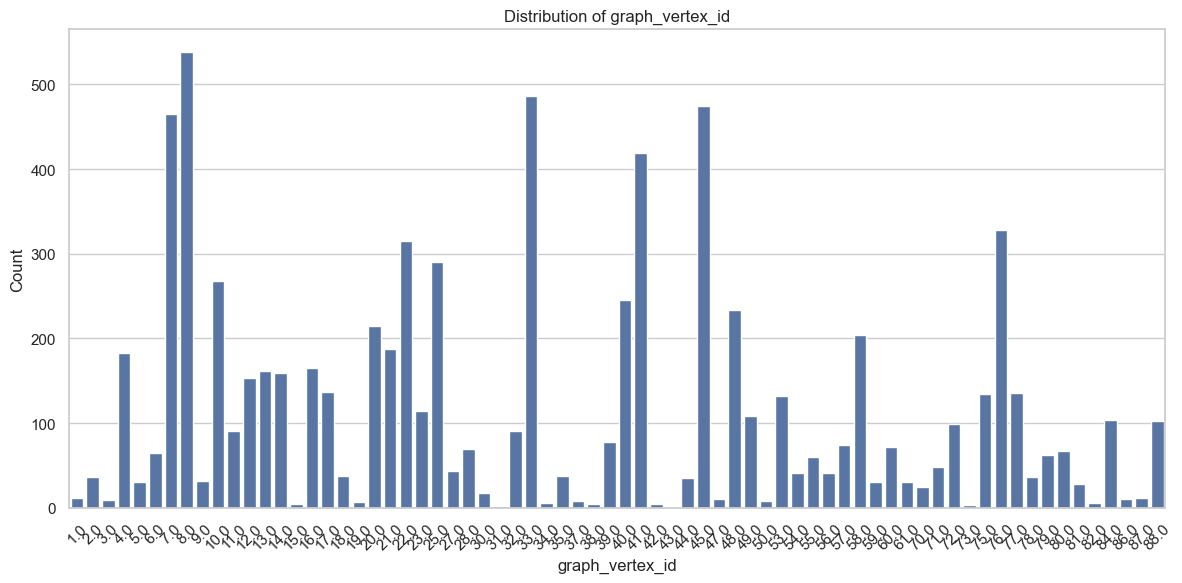


Saved selected columns to temporary file: C:\Users\LOQ\AppData\Local\Temp\tmpqgypr6sr.csv


In [14]:
# Read the original dataset
print(f"Reading original dataset: {ORIGINAL_DATASET_PATH}")
try:
    df_original = pd.read_csv(ORIGINAL_DATASET_PATH)
    print("Successfully read the original dataset.")
    
    # Display basic information
    print(f"\nOriginal dataset shape: {df_original.shape}")
    print("\nColumns in the original dataset:")
    for col in df_original.columns:
        print(f"- {col}")
    
    # Select only the required columns
    print("\nSelecting only 'code_block' and 'graph_vertex_id' columns...")
    df_selected = df_original[['code_block', 'graph_vertex_id']]
    print(f"Selected dataset shape: {df_selected.shape}")
    
    # Display the first few rows
    print("\nFirst 5 rows of the selected columns:")
    display(df_selected.head())
    
    # Check the distribution of graph_vertex_id
    print("\nDistribution of graph_vertex_id:")
    vertex_counts = df_selected['graph_vertex_id'].value_counts()
    print(vertex_counts)
    
    # Visualize the distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=vertex_counts.index, y=vertex_counts.values)
    plt.title('Distribution of graph_vertex_id')
    plt.xlabel('graph_vertex_id')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create a temporary file with the selected columns
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.csv')
    temp_dataset_path = temp_file.name
    temp_file.close()
    
    # Save the selected columns to the temporary file with semicolon delimiter
    df_selected.to_csv(temp_dataset_path, sep=';', index=False)
    print(f"\nSaved selected columns to temporary file: {temp_dataset_path}")
    
    # Set the dataset path for the SVM script
    DATASET_PATH = temp_dataset_path
    
except Exception as e:
    print(f"Error reading the original dataset: {e}")
    print("Using a small sample dataset instead.")
    
    # Create a small sample dataset
    sample_data = '''code_block;graph_vertex_id
"class MyClass:\n    def __init__(self, name):\n        self.name = name";class
"def calculate_sum(a, b):\n    return a + b";function
"x = 10\ny = 20\nz = x + y";variable
"for i in range(10):\n    print(i)";loop
"if x > 10:\n    print('Greater')\nelse:\n    print('Less or equal')";condition'''
    
    # Create a temporary file with the sample data
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.csv')
    temp_dataset_path = temp_file.name
    with open(temp_dataset_path, 'w') as f:
        f.write(sample_data)
    print(f"Created sample dataset at: {temp_dataset_path}")
    
    # Set the dataset path for the SVM script
    DATASET_PATH = temp_dataset_path

## 6. Modify the SVM Training Script for Small Datasets

In [15]:
# Read the svm_train.py file
with open('svm_train.py', 'r') as file:
    content = file.read()

# Create a backup of the original file
with open('svm_train.py.bak', 'w') as backup:
    backup.write(content)
print("Created backup of svm_train.py")

# 1. Fix the DEFAULT_HYPERPARAMS section for small datasets
if 'DEFAULT_HYPERPARAMS' in content:
    pattern = r'DEFAULT_HYPERPARAMS = \{[^\}]*\}'
    new_params = '''DEFAULT_HYPERPARAMS = {
    "svm__C": 1.0,
    "tfidf__min_df": 1,  # Minimum document frequency set to 1 for small datasets
    "tfidf__max_df": 1.0,  # Maximum document frequency set to 100% for small datasets
    "svm__kernel": "linear",
    "tfidf__smooth_idf": True,
    "svm__random_state": RANDOM_STATE,
    "svm__max_iter": MAX_ITER,
}'''
    content = re.sub(pattern, new_params, content)
    print("Modified DEFAULT_HYPERPARAMS for small datasets")

# 2. Fix the KFold parameters to use fewer splits than the number of samples
kfold_pattern = r'kfold_params = \{[^\}]*\}'
new_kfold = '''kfold_params = {
        "n_splits": 2,  # Reduced from 10 to work with small datasets
        "random_state": RANDOM_STATE,
        "shuffle": True,
    }'''
content = re.sub(kfold_pattern, new_kfold, content)
print("Modified KFold parameters to use fewer splits")

# Write the modified content back to the file
with open('svm_train.py', 'w') as file:
    file.write(content)
print("Saved modified svm_train.py")

Created backup of svm_train.py
Modified DEFAULT_HYPERPARAMS for small datasets
Modified KFold parameters to use fewer splits
Saved modified svm_train.py


## 7. Run the SVM Training Script

In [16]:
# Run the script using subprocess
cmd = [sys.executable, "svm_train.py", GRAPH_VER, DATASET_PATH, str(N_TRIALS)]
print("Running command:", " ".join(cmd))

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print("\nOutput:")
    print(result.stdout)
    
    if result.stderr:
        print("\nErrors:")
        print(result.stderr)
except subprocess.CalledProcessError as e:
    print("\nError running the script:")
    print(e.stderr)

Running command: d:\A_Z_NLP\End-To-End-Project\GEN_AI_Projects\finalenv\python.exe svm_train.py 1 C:\Users\LOQ\AppData\Local\Temp\tmpqgypr6sr.csv 0

Output:
vertices parsed: ['class', 'function', 'variable', 'loop', 'condition']
Index(['code_block', 'graph_vertex_id'], dtype='object')
loaded
selecting hyperparameters
A new study created in memory with name: svm with kernels
hyperparams: 
tfidf {'smooth_idf': True, 'min_df': 1, 'max_df': 1.0} 
model {'random_state': 42, 'max_iter': 10000, 'C': 1.0, 'kernel': 'linear'}
metrics: {'test_f1_score': np.float64(0.6212791617026207), 'test_accuracy': np.float64(0.6328735033836543), 'test_f1_std': np.float64(0.004864596639768903), 'test_accuracy_std': np.float64(0.004815200416449783)}
finished


Errors:
[I 2025-05-06 02:28:54,418] A new study created in memory with name: svm with kernels



## 8. Check if the Model Files Were Created

In [17]:
# Check if the model files were created
print(f"Checking if model file exists: {MODEL_DIR}")
print(f"Exists: {os.path.exists(MODEL_DIR)}")

print(f"\nChecking if TF-IDF file exists: {TFIDF_DIR}")
print(f"Exists: {os.path.exists(TFIDF_DIR)}")

# List files in the models directory
print("\nListing files in the models directory:")
if os.path.exists("../models"):
    model_files = os.listdir("../models")
    for file in model_files:
        file_path = os.path.join("../models", file)
        file_size = os.path.getsize(file_path) / 1024  # Size in KB
        print(f"- {file} (Size: {file_size:.2f} KB)")
else:
    print("Models directory does not exist.")

Checking if model file exists: ../models/svm_linear_search_graph_v1.sav
Exists: True

Checking if TF-IDF file exists: ../models/tfidf_hyper_svm_graph_v1.pickle
Exists: True

Listing files in the models directory:
- svm_linear_search_graph_v1.sav (Size: 8421.08 KB)
- tfidf_hyper_svm_graph_v1.pickle (Size: 314.85 KB)


## 9. Summary

This notebook has:
1. Read the original markup_data.csv file
2. Selected only the 'code_block' and 'graph_vertex_id' columns during runtime
3. Created a temporary file with the selected columns
4. Modified the SVM training script for the dataset
5. Run the SVM training script on the selected columns
6. Verified that the model files were created
7. Cleaned up temporary files

The trained model can now be used for predictions.